# Preprocessing

## Enviroment setup and data import

In this part we will setup the environment and import the data used for this study.

In [1]:
import pandas as pd
import numpy as np
import random

# !conda install -c conda-forge folium
# might take 15-30 minutes to resolve environment and install folium
# folimn not necessary till noticed
import folium

# mute warnings
import warnings
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

In [2]:
data = pd.DataFrame(pd.read_csv("taxi_data.csv"))

In [3]:
# find the headers of dataframe
list(data)

['medallion',
 'hack_license',
 'pickup_datetime',
 'dropoff_datetime',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'total_amount']

## Data wrangling

In this part we will perform data wrangling methods. It consists of several parts.
* check for missing data problems
* find appropriate coordinates
* seperate hour, minute, second information for pickup and dropoff time
* omit unnecessary columns

In [4]:
# mising data check

print("missing data numbers: ", data.isnull().sum().sum())

missing data numbers:  0


It has been proved that there is no missing data problems in this dataset.

We have also notice a problem, that although no missing data shown in previous part, some coordinates have no realistic meanings. For example:

In [5]:
print("Numbers of dropoff longitude is 0: ", sum(data["dropoff_longitude"] == 0))
print("Numbers of dropoff latitude is 0: ", sum(data["dropoff_latitude"] == 0))

Numbers of dropoff longitude is 0:  156
Numbers of dropoff latitude is 0:  137


Therefore, we filter those taxi rides with pickup and dropoff location in a proper range.

In [6]:
# use pickup coordinates as boundaries

ny_lat_min = 40.6997
ny_lat_max = 40.8776
ny_lon_min = -74.0197
ny_lon_max = -73.9067

min_lon, max_lon, min_lat, max_lat = (ny_lon_min,
                                      ny_lon_max,
                                      ny_lat_min,
                                      ny_lat_max)

print("Minimum pickup longitude: ", min_lon)
print("Maximum pickup longitude: ", max_lon)
print("Minimum pickup latitude: ", min_lat)
print("Maximum pickup latitude: ", max_lat)

Minimum pickup longitude:  -74.0197
Maximum pickup longitude:  -73.9067
Minimum pickup latitude:  40.6997
Maximum pickup latitude:  40.8776


In [7]:
# filter the dropoff coordinates

def coordinate_filter(x, min_val, max_val):
    return min_val <= x <= max_val

data["dropoff_latitude_inrange"] = data["dropoff_latitude"].apply(
    lambda x: coordinate_filter(x, min_lat, max_lat)
)

data["dropoff_longitude_inrange"] = data["dropoff_longitude"].apply(
    lambda x: coordinate_filter(x, min_lon, max_lon)
)

data["pickup_latitude_inrange"] = data["pickup_latitude"].apply(
    lambda x: coordinate_filter(x, min_lat, max_lat)
)

data["pickup_longitude_inrange"] = data["pickup_longitude"].apply(
    lambda x: coordinate_filter(x, min_lon, max_lon)
)

In [8]:
# transform datetime to HMS, add to dataframe

datetime_obj_pickup = pd.to_datetime(data["pickup_datetime"])
data["pickup_hour"] = datetime_obj_pickup.dt.hour
data["pickup_minute"] = datetime_obj_pickup.dt.minute
data["pickup_second"] = datetime_obj_pickup.dt.second

datetime_obj_dropoff = pd.to_datetime(data["dropoff_datetime"])
data["dropoff_hour"] = datetime_obj_dropoff.dt.hour
data["dropoff_minute"] = datetime_obj_dropoff.dt.minute
data["dropoff_second"] = datetime_obj_dropoff.dt.second

In [9]:
# create psudo-timestamp variables

data["pickup_timestamp"] = (data["pickup_hour"] * 60 * 60 
                            + data["pickup_minute"] * 60
                            + data["pickup_second"])

data["dropoff_timestamp"] = (data["dropoff_hour"] * 60 * 60 
                            + data["dropoff_minute"] * 60
                            + data["dropoff_second"])

In [10]:
# select qualified rows
data_remove_row = data.loc[
    data["dropoff_latitude_inrange"] &
    data["dropoff_longitude_inrange"] &
    data["pickup_latitude_inrange"] &
    data["pickup_longitude_inrange"],
    :
]

# select necessary columns
data_final = data_remove_row.iloc[:, 4:11].join(data_remove_row.iloc[:, 15:])

In [11]:
# have a glimpse of the data
data_final = data_final.reset_index(drop = True)
data_final

,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_hour,pickup_minute,pickup_second,dropoff_hour,dropoff_minute,dropoff_second,pickup_timestamp,dropoff_timestamp
0,1801,5.0,-74.013359,40.714722,-73.972649,40.764694,23.5,18,30,59,19,1,57,66659,68517
1,172,1.0,-73.964958,40.760021,-73.971352,40.751297,7.0,19,19,7,19,22,40,69547,69760
2,260,2.0,-73.960114,40.762142,-73.974434,40.744308,8.5,2,31,6,2,34,46,9066,9286
3,521,2.0,-73.968163,40.802277,-73.984322,40.780106,9.0,12,20,6,12,29,27,44406,44967
4,1068,4.0,-73.960548,40.813354,-73.981071,40.764908,16.0,10,35,31,10,53,57,38131,39237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397994,552,2.0,-73.957405,40.722355,-73.940079,40.715858,11.4,23,59,51,0,9,3,86391,543
397995,395,2.0,-73.987450,40.757973,-74.003304,40.750622,8.0,23,59,51,0,6,26,86391,386
397996,244,1.0,-73.955299,40.714184,-73.957001,40.720531,6.0,23,59,53,0,3,57,86393,237
397997,948,2.0,-73.993874,40.742134,-73.967232,40.756779,16.2,23,59,58,0,15,46,86398,946


397,999 observations and 15 columns are chosen.

## Zone seperation and visualization

In this part we plan to seperate the data in different zones to simplify the problem. The zones would be seperated based on the following ideas.
* generally based on coordinates of the pickup and dropoff locations
* not too small which problem cannot be simplied
* not too large which creates too few cross-zone travels

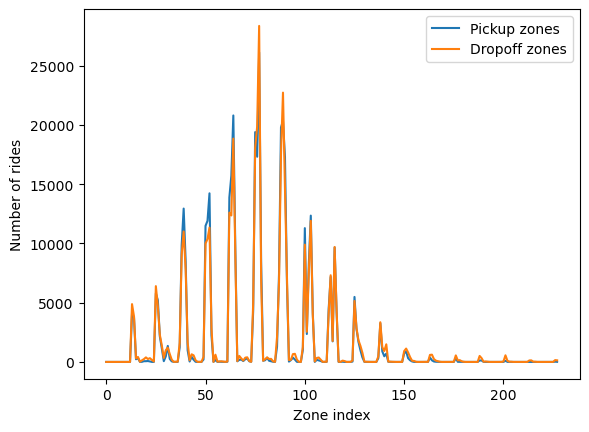

In [12]:
# a helper class to do zone seperation and add marks
from ZoneSeperation import *

# to adjust the expected zone numbers, set different parameters
zone_seperator = Zone_seperation(data_final, 200)
data_zone = zone_seperator.finilize()
number_of_zone = zone_seperator.no_area

In [13]:
# to access the number of rides in each zone

zone_count = pd.DataFrame({"pickup": zone_seperator.pickup_count,
                           "dropoff": zone_seperator.dropoff_count})
pd.set_option('display.max_rows', None)
zone_count

,pickup,dropoff
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [14]:
# reset the maximum rows for display
pd.set_option('display.max_rows', 10)

***Below part requires installation of folium***

Here's the visualization of the coordinates. As there are too many rows in the original dataset, we can only sample a few.

In [15]:
y = data_zone.sample(n = 2000)

# Manhattan coordinates
nyc_latitude = (ny_lat_min + ny_lat_max) / 2
nyc_longitude = (ny_lon_min + ny_lon_max) / 2

map_manhattan = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

# 2000 samples pickup location plot
for latitude, longitude in zip(y["pickup_latitude"], y["pickup_longitude"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius = 0.5,
        color = "green",
        fill = True,
        fill_color = "green",
        fill_opacity = 0.3,
        parse_html = False).add_to(map_manhattan)
map_manhattan

## Zone selection (to be discussed)

The main idea of this part is to select those parts with rides over a specific cutoff. Since the original zone seperation was conducted on a "rectangular" area, it is hard to select only the areas in Manhattan as its bounaries are not parallel to longitude or latitude line. In order to imporve the simulation, we would set a cutoff number and only areas that have pickup and dropoff rides both surpassing the cutoff could be selected.

Number of selected zones:  40


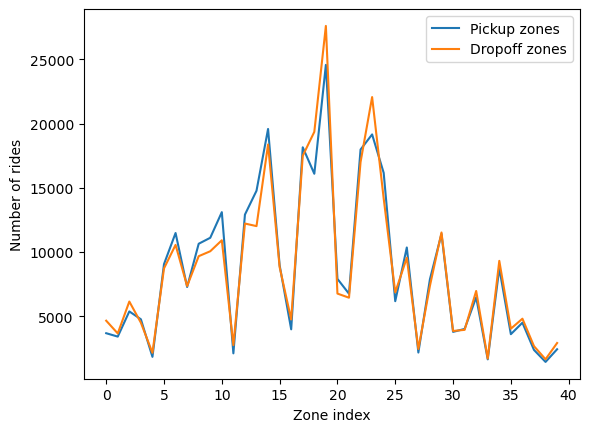

In [16]:
# to fulfill the ideas above, create another class for help
# change the parameter in cutoff to select differenct cutoffs
from ZoneSelection import Zone_selection

zone_selector = Zone_selection(df = data_final,
                               cutoff = 1500,
                               number_of_zone = number_of_zone)

data_final_select = zone_selector.result_df

There have been different tests towards `cutoff = 200, 500, 1000, 1500` and 1500 seems to be the best.

In [17]:
# compare the possible areas without any zone selection
y = data_final_select.sample(n = 2000)

# Manhattan coordinates
nyc_latitude = (ny_lat_min + ny_lat_max) / 2
nyc_longitude = (ny_lon_min + ny_lon_max) / 2

map_manhattan = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

# 2000 samples pickup location plot
for latitude, longitude in zip(y["pickup_latitude"], y["pickup_longitude"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius = 0.5,
        color = "purple",
        fill = True,
        fill_color = "purple",
        fill_opacity = 0.3,
        parse_html = False).add_to(map_manhattan)
map_manhattan

We can see most points lay in Manhattan rather than other areas.

### Center plotting

We can try plot the center of each selected zone.

In [38]:
# find out the average pickup latitude and longitude
df_centered_pickup = data_final_select[[
    "pickup_longitude",
    "pickup_latitude",
    "pickup_zone"
]].groupby("pickup_zone").mean()

# Manhattan coordinates
nyc_latitude = (ny_lat_min + ny_lat_max) / 2
nyc_longitude = (ny_lon_min + ny_lon_max) / 2
map_pickup_location = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)


# plot the centers for pickup location
for latitude, longitude in zip(df_centered_pickup["pickup_latitude"],
                               df_centered_pickup["pickup_longitude"]):
    random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    folium.CircleMarker(
        [latitude, longitude],
        radius = 4,
        color = random_color,
        fill = True,
        fill_color = random_color,
        fill_opacity = 1,
        parse_html = False).add_to(map_pickup_location)
map_pickup_location

In [40]:
# find out the average dropoff latitude and longitude
df_centered_dropoff = data_final_select[[
    "dropoff_longitude",
    "dropoff_latitude",
    "dropoff_zone"
]].groupby("dropoff_zone").mean()

# Manhattan coordinates
nyc_latitude = (ny_lat_min + ny_lat_max) / 2
nyc_longitude = (ny_lon_min + ny_lon_max) / 2
map_dropoff_location = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)


# plot the centers for pickup location
for latitude, longitude in zip(df_centered_dropoff["dropoff_latitude"],
                               df_centered_dropoff["dropoff_longitude"]):
    random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    folium.CircleMarker(
        [latitude, longitude],
        radius = 4,
        color = random_color,
        fill = True,
        fill_color = random_color,
        fill_opacity = 1,
        parse_html = False).add_to(map_dropoff_location)
map_dropoff_location

In [41]:
data_final_select.reset_index()

,index,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_hour,pickup_minute,...,dropoff_minute,dropoff_second,pickup_timestamp,dropoff_timestamp,pickup_latitude_count,pickup_longitude_count,dropoff_latitude_count,dropoff_longitude_count,pickup_zone,dropoff_zone
0,0,1801,5.0,-74.013359,40.714722,-73.972649,40.764694,23.5,18,30,...,1,57,66659,68517,2,1,7,5,2,23
1,1,172,1.0,-73.964958,40.760021,-73.971352,40.751297,7.0,19,19,...,22,40,69547,69760,7,6,6,5,24,19
2,2,260,2.0,-73.960114,40.762142,-73.974434,40.744308,8.5,2,31,...,34,46,9066,9286,7,7,5,5,25,15
3,3,521,2.0,-73.968163,40.802277,-73.984322,40.780106,9.0,12,20,...,29,27,44406,44967,11,6,9,4,39,31
4,7,512,3.0,-73.973289,40.792690,-73.973602,40.763554,10.5,6,9,...,18,0,22140,22680,10,5,7,5,36,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347809,397992,907,7.0,-74.005219,40.720135,-73.951187,40.770283,27.0,23,59,...,14,56,86389,896,3,2,8,7,5,29
347810,397993,465,2.0,-73.992271,40.729198,-73.975388,40.757710,10.0,23,59,...,7,35,86390,455,4,3,6,5,9,19
347811,397995,395,2.0,-73.987450,40.757973,-74.003304,40.750622,8.0,23,59,...,6,26,86391,386,6,4,6,2,18,16
347812,397997,948,2.0,-73.993874,40.742134,-73.967232,40.756779,16.2,23,59,...,15,46,86398,946,5,3,6,6,13,20


Therefore, if we include the zone-selection part, we would have 347,814 observations and 22 columns.

In [42]:
# save cleaned dataset for analysis
data_final_select.to_csv('nyc_data_cleaned.csv', index=False)